#Neural Network Classification with pytorch
Classification is the problem of predicting whether something is one thing or another (There can be multiple things as the options)

##1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles
#Make 1000 samples
n_samples = 1000
#Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: \n{X[:5]}")
print(f"First 5 samples of y: \n{y[:5]}")

First 5 samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
[1 1 1 1 0]


In [5]:
X[0,0], X[2,0], X[3,1]

(0.7542462506997276, -0.8153919335251194, 0.6928827699017868)

In [6]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label" : y})
circles.head(5)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


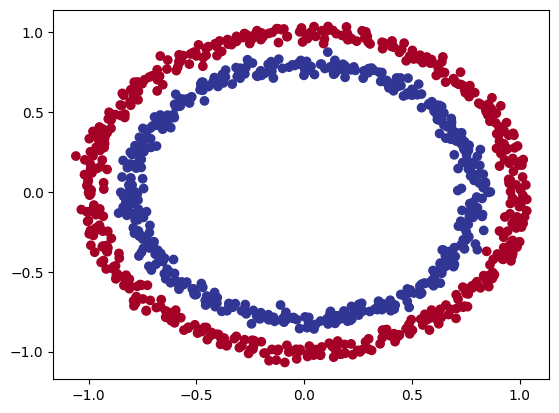

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

Note: The data we are working with is called a toy dataset (dataset that is small enough to experiment with but still sizeable enough to practice the fundamentals)

## Checking input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
#View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and for y: {y_sample.shape}") #y is a scalar so does not have any features

Values for one sample of X: [0.75424625 0.23148074] and for y: 1
Shapes for one sample of X: (2,) and for y: ()


###Turn data into tensors and create train and test split

In [10]:
import torch

In [11]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
type(X), X.dtype

(torch.Tensor, torch.float32)

In [12]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
#Split data into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,#0.2 = 20%
                                                    random_state = 42) #For random splits


In [14]:
len(X_train), len(X_test)

(800, 200)

## Building a model to classify blue and red dots
1. Setup device agnostic code
2. Construct a model by subclassing nn.Module
3. Define loss function and optimizer
4. Create a training and test loop


In [15]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
2. Define a forward method
3. Instantiate an instance of our model class and send it to the target device

In [16]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2,
                             out_features = 5) #Takes in 2 features and upscales to 5 features

    self.layer_2 = nn.Linear(in_features = 5,
                             out_features = 1) #Takes in 5 features from previous layer and outputs a single feature(y)


  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

#Instantiate model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

Replicating the model above using nn.Sequential()

In [18]:
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2647, -0.5221],
                      [ 0.1256, -0.3999],
                      [-0.1974,  0.6080],
                      [-0.5901, -0.0092],
                      [-0.4804,  0.2012]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0093,  0.6088,  0.2364,  0.6860,  0.3996], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4181,  0.2063, -0.3421, -0.4001,  0.4467]], device='cuda:0')),
             ('1.bias', tensor([-0.2047], device='cuda:0'))])

In [20]:
#Making predictions with untrained model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Lenght of test samples: {len(X_test)}, Shape: {X_test.shape} \n")
print(f"First ten predictions:\n {untrained_preds[:10]}")
print(f"\nFirst ten labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Lenght of test samples: 200, Shape: torch.Size([200, 2]) 

First ten predictions:
 tensor([[-0.5450],
        [-0.6585],
        [-0.1323],
        [-0.6624],
        [ 0.0506],
        [-0.0201],
        [-0.4846],
        [-0.3346],
        [-0.1406],
        [-0.6640]], device='cuda:0')

First ten labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup a loss function and optimizer

For classification binary cross entropy or categorical cross entropy loss functions

For optimizers two of the most common optimizers are SGD and Adam

For the loss function we'll be using `torch.nn.BCEWithLogitsLoss()`

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a



In [21]:
#loss_func = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_func = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built in

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [22]:
#Calculating Accuracy - Out of 100 examples, what percentage does our model get right
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # eq: equals, item because we want it as a single value
  acc = (correct/len(y_pred)) * 100 #TP + TN/Total Predictions
  return acc

## Training our model
1. Forward pass
2. Calculate Loss
3. optimizer zero grad
4. loss backward
5. Optimizer step

### Going from raw logits to prediction probabilities to prediction labels

Our models outputs are going to be raw logits

We can convert these logits into prediction probabilities by passing them through some kind of activation function e.g sigmoid for binary cross entropy and softmax for multiclass classification

Then we can convert our model's prediction probabilities to prediction labels either by rounding them or taking the argmax()

In [23]:
#View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5450],
        [-0.6585],
        [-0.1323],
        [-0.6624],
        [ 0.0506]], device='cuda:0')

In [24]:
#Use the sigmoid activation function on our model logits in order to turn them into prediction probabilities
y_preds_prob = torch.sigmoid(y_logits)
y_preds_prob

tensor([[0.3670],
        [0.3411],
        [0.4670],
        [0.3402],
        [0.5126]], device='cuda:0')

For our predicition probability values we need to perform a range style rounding on them
* `y_preds_prob` >= 0.5, `y = 1` class 1
* `y_preds_prob` < 0.5, `y = 0` class 0


In [25]:
torch.round(y_preds_prob)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]], device='cuda:0')

In [26]:
#Find the predicted labels
y_preds = torch.round(y_preds_prob)

#In full(logits -> prediction probabilities -> prediction labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#Get rid of extra dimension
y_preds.squeeze()

tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## Building a training and testing loop


In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

#Put data onto target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

#Building training and evaluation loop
for epoch in range(epochs):
  ###Training
  model_0.train()
  #1. Forward Pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  #2. Calculate Loss and Accuracy
  loss = loss_func(y_logits, #Our loss function expects to get raw logits and it will perform sigmoid by itself.
                   y_train)

  accuracy = accuracy_func(y_true = y_train,y_pred = y_pred)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backwards
  loss.backward()

  #5. Optimizer step
  optimizer.step()


  ###Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss and accuracy
    test_loss = loss_func(test_logits, y_test)
    test_accuracy = accuracy_func(y_true = y_test,y_pred = test_pred)

    # 3. Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch : {epoch}")
      print(f"Training Loss : {loss:.5f} ")
      print(f"Training Accuracy: {accuracy:.2f} %")
      print(f"Testing Loss: {test_loss:.5f}")
      print(f"Testing Accuracy : {test_accuracy:.2f} % \n")

Epoch : 0
Training Loss : 0.71198 
Training Accuracy: 46.00 %
Testing Loss: 0.70194
Testing Accuracy : 50.50 % 

Epoch : 10
Training Loss : 0.70347 
Training Accuracy: 47.50 %
Testing Loss: 0.69455
Testing Accuracy : 51.50 % 

Epoch : 20
Training Loss : 0.70000 
Training Accuracy: 48.12 %
Testing Loss: 0.69210
Testing Accuracy : 52.50 % 

Epoch : 30
Training Loss : 0.69811 
Training Accuracy: 48.62 %
Testing Loss: 0.69121
Testing Accuracy : 53.50 % 

Epoch : 40
Training Loss : 0.69687 
Training Accuracy: 48.75 %
Testing Loss: 0.69090
Testing Accuracy : 53.50 % 

Epoch : 50
Training Loss : 0.69597 
Training Accuracy: 48.75 %
Testing Loss: 0.69085
Testing Accuracy : 53.00 % 

Epoch : 60
Training Loss : 0.69530 
Training Accuracy: 49.12 %
Testing Loss: 0.69094
Testing Accuracy : 53.00 % 

Epoch : 70
Training Loss : 0.69479 
Training Accuracy: 48.88 %
Testing Loss: 0.69110
Testing Accuracy : 52.50 % 

Epoch : 80
Training Loss : 0.69440 
Training Accuracy: 48.62 %
Testing Loss: 0.69131
Test

##Make predictions and evaluate

From the metrics it seems that our model is not learning anything

So to inspect it, make predictions and visualise them

importing a function called `plot_decision_boundary()`

https://madewithml.com/courses/foundations/neural-networks/

In [29]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

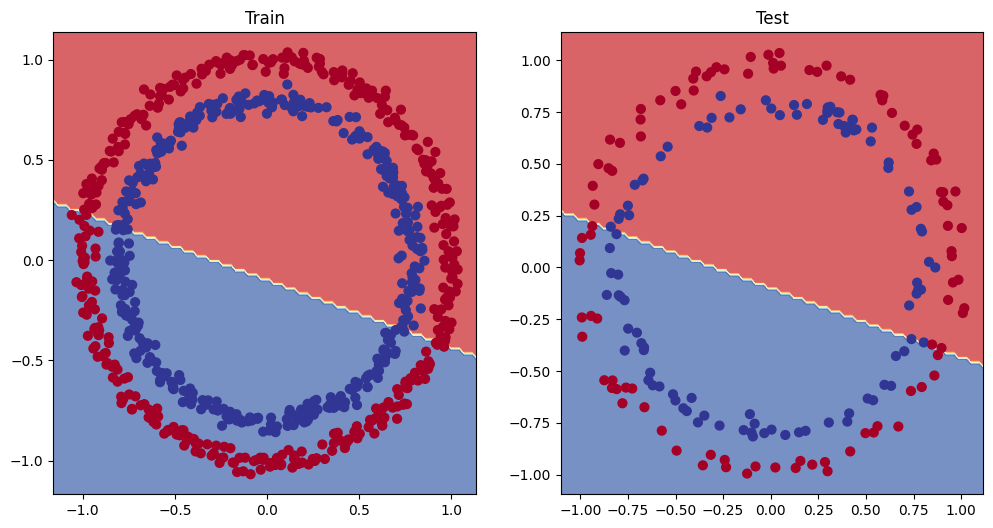

In [30]:
#Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1) #Rows, columns, index
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

##Improving our model.

Straight linear lines can not be used to predict.

* Add more layers - Give model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to ten?
* Fit for longer - Increase number of epochs
* Change the Activation Function
* Change the Learning Rate
* Change the Loss Function


In [31]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2476, -0.4317],
                      [ 0.1361, -0.3465],
                      [-0.2094,  0.5425],
                      [-0.6087, -0.1030],
                      [-0.4540,  0.3299]])),
             ('0.bias', tensor([0.0319, 0.6318, 0.2050, 0.6458, 0.4516])),
             ('1.weight',
              tensor([[ 0.2843,  0.1843, -0.1817, -0.3732,  0.5361]])),
             ('1.bias', tensor([-0.0966]))])

Adding more hidden units: 5 -> 10

Increasing number of layers 2 -> 3

Increasing number of epochs 100 -> 1000

In [32]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)


  def forward(self, x):
    #z = self.layer_1(x)
    #z = self.layer_2(z)
    #z = self.layer_3(z)
    #return z # z = logits
    return self.layer_3(self.layer_2(self.layer_1(x))) #More speedy behind the scenes


model_1 = CircleModelV1().to(device)

model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
#Create a loss function
loss_func = nn.BCEWithLogitsLoss()
#Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [34]:
#Write a training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ###Training
  model_1.train()
  #Forward Pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Calculate the loss/accuracy
  loss = loss_func(y_logits, y_train)
  accuracy = accuracy_func(y_true = y_train,y_pred = y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  #Backpropagation
  loss.backward()

  #Optimizer step
  optimizer.step()

  ###TESTING
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # Calculate loss
    test_loss = loss_func(test_logits, y_test)
    test_accuracy = accuracy_func(y_true = y_test, y_pred = test_pred)

  #Print out whats happening
  if epoch % 100 == 0:
    print(f"Epoch : {epoch} | training loss = {loss} | training accuracy = {accuracy}% | test loss = {test_loss} | test accuracy = {test_accuracy}%")

Epoch : 0 | training loss = 0.6939550638198853 | training accuracy = 50.875% | test loss = 0.6926146745681763 | test accuracy = 51.0%
Epoch : 100 | training loss = 0.6930478811264038 | training accuracy = 50.375% | test loss = 0.6937904357910156 | test accuracy = 48.0%
Epoch : 200 | training loss = 0.6929860711097717 | training accuracy = 51.125% | test loss = 0.6943727135658264 | test accuracy = 46.0%
Epoch : 300 | training loss = 0.6929804682731628 | training accuracy = 51.625% | test loss = 0.6945767998695374 | test accuracy = 45.0%
Epoch : 400 | training loss = 0.6929799318313599 | training accuracy = 51.125% | test loss = 0.6946452260017395 | test accuracy = 46.0%
Epoch : 500 | training loss = 0.6929798722267151 | training accuracy = 51.0% | test loss = 0.6946680545806885 | test accuracy = 46.0%
Epoch : 600 | training loss = 0.6929798722267151 | training accuracy = 51.0% | test loss = 0.6946756839752197 | test accuracy = 46.0%
Epoch : 700 | training loss = 0.6929798722267151 | tra

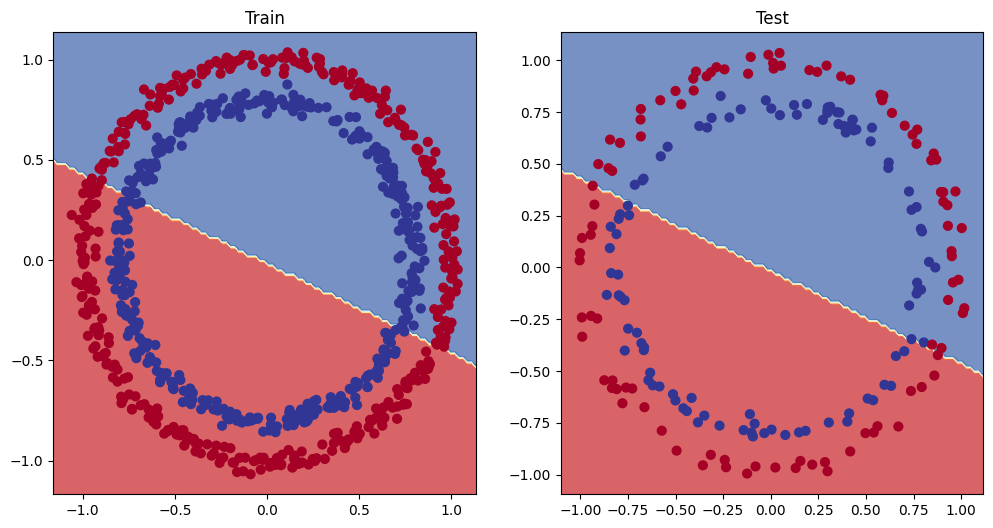

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Missing piece of our model: NON LINEARITY


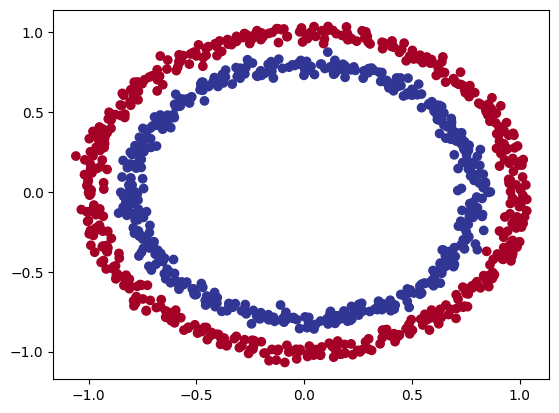

In [36]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [37]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a model with non linearity

In [38]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU() #Relu is a non linear activation function

  def forward(self, x):
    #Where should we place our non linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)
model_2


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [39]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

In [40]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [41]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 2000
for epoch in range(epochs):
  ###Training
  #Forward Pass
  model_2.train()
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Calculate loss
  loss = loss_func(y_logits, y_train)
  accuracy = accuracy_func(y_true = y_train, y_pred = y_pred)

  #Optimizer Zero Grad
  optimizer.zero_grad()

  #Backpropagation
  loss.backward()

  #Optimizer Step
  optimizer.step()

  ###Testing
  model_2.eval()
  with torch.inference_mode():
    #Forward pass
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #Calculate Loss
    test_loss = loss_func(test_logits, y_test)
    test_accuracy = accuracy_func(y_true = y_test, y_pred = test_pred)

  #Print out whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train Loss = {loss:.5f} | Train Accuracy = {accuracy:.2f} % | Test Loss = {test_loss:.5f} | Test Accuracy = {test_accuracy:.2f} %")

Epoch: 0 | Train Loss = 0.69295 | Train Accuracy = 50.00 % | Test Loss = 0.69319 | Test Accuracy = 50.00 %
Epoch: 100 | Train Loss = 0.69115 | Train Accuracy = 52.88 % | Test Loss = 0.69102 | Test Accuracy = 52.50 %
Epoch: 200 | Train Loss = 0.68977 | Train Accuracy = 53.37 % | Test Loss = 0.68940 | Test Accuracy = 55.00 %
Epoch: 300 | Train Loss = 0.68795 | Train Accuracy = 53.00 % | Test Loss = 0.68723 | Test Accuracy = 56.00 %
Epoch: 400 | Train Loss = 0.68517 | Train Accuracy = 52.75 % | Test Loss = 0.68411 | Test Accuracy = 56.50 %
Epoch: 500 | Train Loss = 0.68102 | Train Accuracy = 52.75 % | Test Loss = 0.67941 | Test Accuracy = 56.50 %
Epoch: 600 | Train Loss = 0.67515 | Train Accuracy = 54.50 % | Test Loss = 0.67285 | Test Accuracy = 56.00 %
Epoch: 700 | Train Loss = 0.66659 | Train Accuracy = 58.38 % | Test Loss = 0.66322 | Test Accuracy = 59.00 %
Epoch: 800 | Train Loss = 0.65160 | Train Accuracy = 64.00 % | Test Loss = 0.64757 | Test Accuracy = 67.50 %
Epoch: 900 | Train Lo

In [42]:
model_2.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.9300,  1.5243],
                      [-0.5232,  1.9216],
                      [-0.1549,  0.1427],
                      [-2.3392, -0.1767],
                      [ 0.6889, -2.3658],
                      [ 1.2308, -0.0741],
                      [ 1.6332,  0.1051],
                      [ 0.3410, -0.0998],
                      [ 0.8671,  0.7070],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.2412, -0.9001, -0.2872, -0.4221, -0.5646, -0.5747, -0.7351, -0.4252,
                      -0.2219, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0311, -0.7215,  0.2441, -0.3385, -0.4142, -0.0497, -0.2312,  0.2555,
                       -0.1172, -0.0997],
                      [ 1.5930,  1.8717,  0.1331,  2.1387,  2.0953,  1.0247,  1.5361,  0.0566,
                        0.9802, -0.1927],
                      [-0.3130, -0.124

### Evaluating our model trained with non linear activation function

In [43]:
model_2.eval()
with torch.inference_mode():
  y_logits = model_2(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

y_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

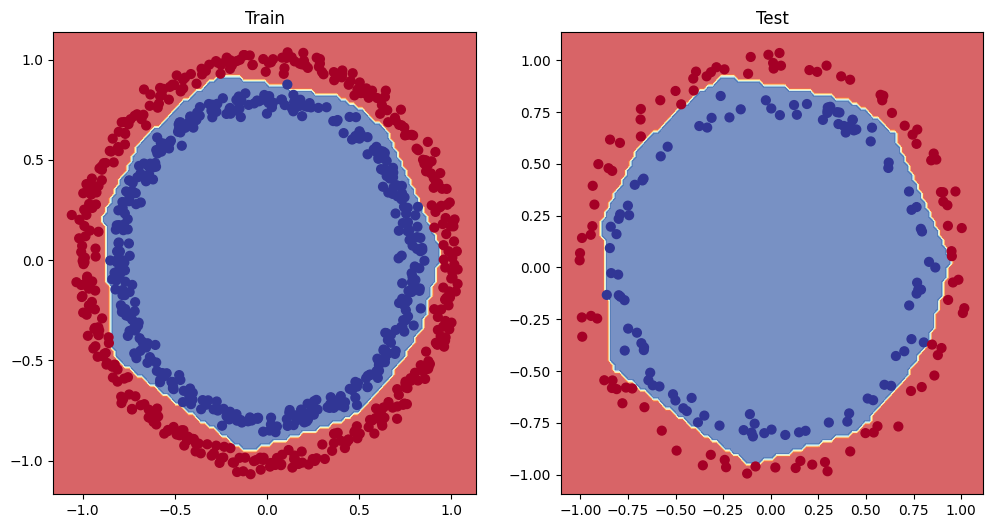

In [44]:
#Plot decision boundaries
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

##Replicating non linear activation functions
Neural Networks; Rather than us telling the model what to learn, we give it tools to discover the patterns in the data on its own.


These tools are linear and non linear functions

In [45]:
#Creating a tensor to start with
import torch
A = torch.arange(start = -10, end = 10, step = 1.0)

In [46]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

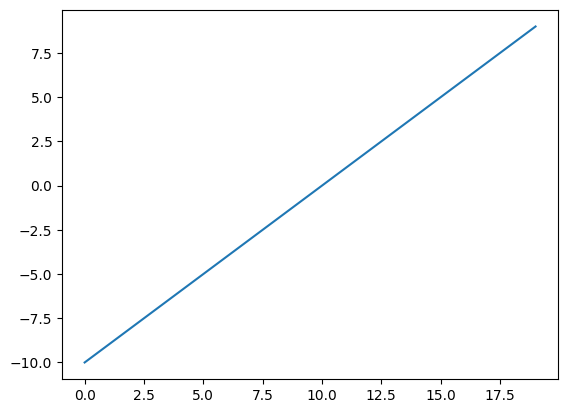

In [47]:
#Visualize the data
plt.plot(A)

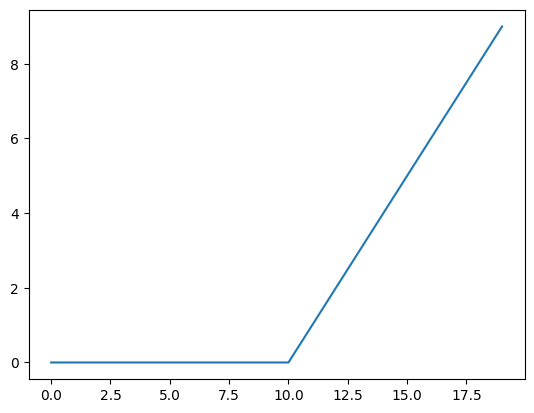

In [48]:
plt.plot(torch.relu(A))

In [49]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) #If 0 is max return 0, if x is max return x

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

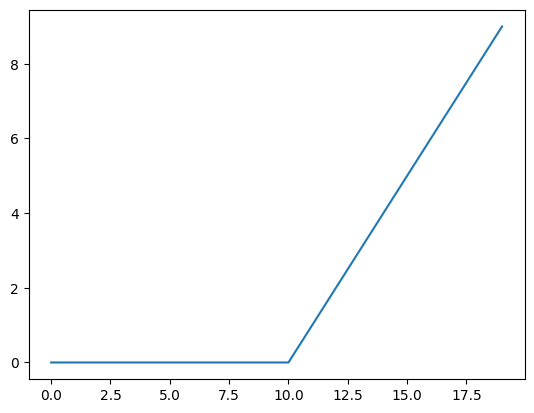

In [50]:
#Plot Relu
plt.plot(relu(A))

In [51]:
#Doing the same for sigmoid. Σ(x) = 1/ (1+e^ (-x))
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

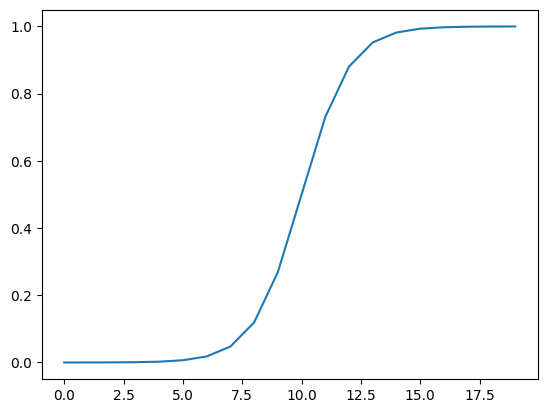

In [52]:
plt.plot(torch.sigmoid(A))

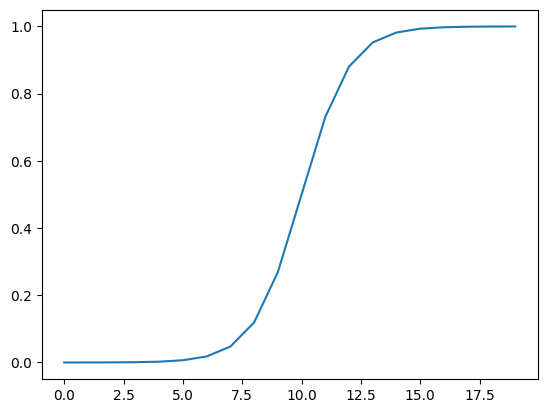

In [53]:
plt.plot(sigmoid(A))

## MultiClass Classification problem.

### Creating a toy multiclass dataset

In [99]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [122]:
#Set the hyperparametes for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42 #Generally hyperparameters set at start of the notebook are capitalized

In [123]:
#Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, #Move the clusters around
                            random_state = RANDOM_SEED)


In [124]:
#Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) #Cross Entropy requires input in long tensor(64 bit integer format)

In [125]:
#Train test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

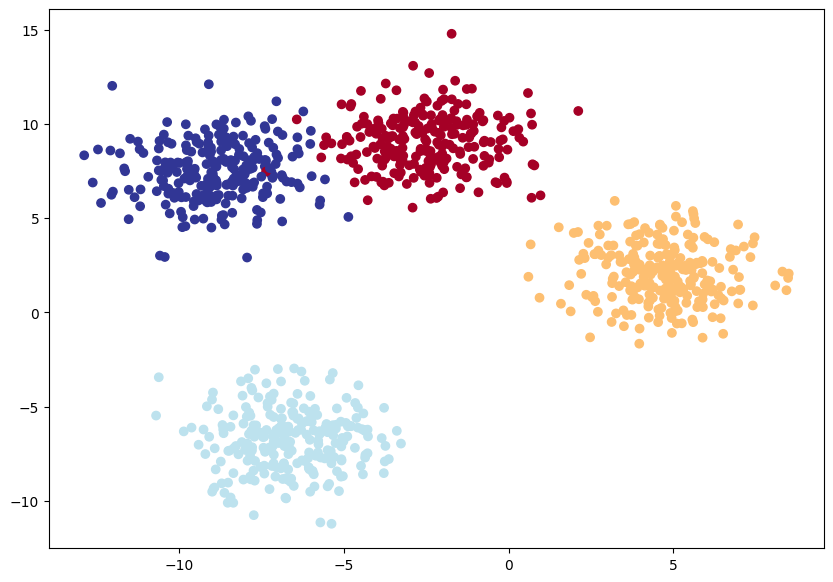

In [126]:
#Visualising the data
plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)

###Building multiclass classification model

In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [128]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()

    #Sequential just passes the data through each of the layers one by one
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
        )
  def forward(self, x):
    return self.linear_layer_stack(x)

In [129]:
#Create an instance of the model and send it to the target device
model_3 = BlobModel(input_features = 2,
                    output_features = 4).to(device)

In [130]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

###Creating loss function and optimizer for multiclass model

In [131]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_3.parameters(),
                            lr = 0.1)

### Getting predicition probabilities for multiclass

In order to evaluate, train and test the model we need to convert our model's outputs(logits) to predicition probabilities and then to predicition labels



In [132]:
X_blob_test = X_blob_test.to(device)
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_blob_test)
y_logits[:5]

tensor([[ 0.2519,  0.2797, -0.0558, -0.2690],
        [-0.2217, -0.1392,  0.4193, -0.4493],
        [-0.3817,  0.2051,  0.1333, -0.9696],
        [ 0.2566,  0.3394, -0.1508, -0.3086],
        [ 0.1458, -0.0711,  0.1607, -0.1950]], device='cuda:0')

In [133]:
#Convert our model's prediction outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2519,  0.2797, -0.0558, -0.2690],
        [-0.2217, -0.1392,  0.4193, -0.4493],
        [-0.3817,  0.2051,  0.1333, -0.9696],
        [ 0.2566,  0.3394, -0.1508, -0.3086],
        [ 0.1458, -0.0711,  0.1607, -0.1950]], device='cuda:0')
tensor([[0.2979, 0.3062, 0.2190, 0.1769],
        [0.2092, 0.2272, 0.3971, 0.1666],
        [0.1989, 0.3577, 0.3329, 0.1105],
        [0.3012, 0.3272, 0.2004, 0.1712],
        [0.2832, 0.2280, 0.2874, 0.2014]], device='cuda:0')


In [134]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [135]:
#Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim = 1)
print(y_preds)

tensor([1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
        2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2,
        1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2,
        1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2,
        1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2,
        1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2,
        1, 2, 1, 2, 2, 1, 1, 1], device='cuda:0')


In [136]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### Creating training loop and testing loop for multiclass

In [138]:
#Building a training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

epochs = 100
for epoch in range(epochs):
  ###Training
  model_3.train()
  #Forward Pass
  y_logits = model_3(X_blob_train)
  y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
  #Calculate Loss
  loss = loss_func(y_logits, y_blob_train)
  accuracy = accuracy_func(y_true = y_blob_train, y_pred = y_preds)
  #optimizer zero grad
  optimizer.zero_grad()
  #BackPropagation
  loss.backward()
  #optimizer step
  optimizer.step()

  ###Testing
  model_3.eval()
  with torch.inference_mode():
    y_test_logits = model_3(X_blob_test)
    y_test_preds = torch.softmax(y_test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_func(y_test_logits, y_blob_test)
    test_accuracy = accuracy_func(y_true = y_blob_test, y_pred = y_test_preds)

  if epoch % 10 == 0:
    print(f"Epoch : {epoch} | Train Loss : {loss:.5f} | Train Accuracy : {accuracy:.2f} % | Test Loss : {test_loss:.5f} | Test Accuracy : {test_accuracy:.2f} %")

Epoch : 0 | Train Loss : 0.04133 | Train Accuracy : 99.25 % | Test Loss : 0.03195 | Test Accuracy : 99.50 %
Epoch : 10 | Train Loss : 0.03855 | Train Accuracy : 99.25 % | Test Loss : 0.02913 | Test Accuracy : 99.50 %
Epoch : 20 | Train Loss : 0.03645 | Train Accuracy : 99.25 % | Test Loss : 0.02696 | Test Accuracy : 99.50 %
Epoch : 30 | Train Loss : 0.03479 | Train Accuracy : 99.25 % | Test Loss : 0.02523 | Test Accuracy : 99.50 %
Epoch : 40 | Train Loss : 0.03347 | Train Accuracy : 99.25 % | Test Loss : 0.02383 | Test Accuracy : 99.50 %
Epoch : 50 | Train Loss : 0.03239 | Train Accuracy : 99.25 % | Test Loss : 0.02266 | Test Accuracy : 99.50 %
Epoch : 60 | Train Loss : 0.03150 | Train Accuracy : 99.25 % | Test Loss : 0.02168 | Test Accuracy : 99.50 %
Epoch : 70 | Train Loss : 0.03074 | Train Accuracy : 99.25 % | Test Loss : 0.02084 | Test Accuracy : 99.50 %
Epoch : 80 | Train Loss : 0.03010 | Train Accuracy : 99.25 % | Test Loss : 0.02011 | Test Accuracy : 99.50 %
Epoch : 90 | Train L

###Making predictions and evaluating the multiclass model

In [141]:
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_blob_test)
y_preds = torch.softmax(y_logits, dim = 1)
y_labels = torch.argmax(y_preds, dim = 1)
y_labels

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [142]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [143]:
y_blob_test.eq(y_labels)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

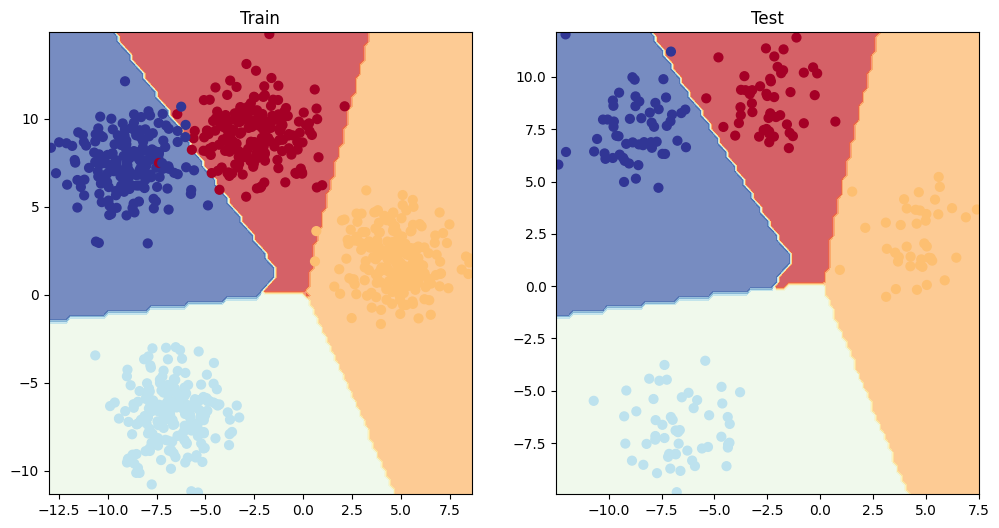

In [144]:
#Plot decision boundaries
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)

## A few more classification metrics

* Accuracy
* Recall
* Precision
* F1 Score
* Confusion Matrix
* Classification Report


In [149]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [155]:
from torchmetrics import Accuracy
#Setup metric
torchmetric_accuracy = Accuracy(task = "multiclass", num_classes = 4).to(device)

torchmetric_accuracy(y_labels, y_blob_test)

tensor(0.9950, device='cuda:0')

In [ ]:
###Section 2 completed here !!!